# Quantum Process Tomography

* **Last Updated:** Jan 24, 2019
* **Requires:** qiskit-terra 0.7

In [1]:
# Needed for functions
import numpy as np
import time

# Import QISKit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.tools.qi.qi import outer

# Tomography functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('../qiskit_ignis')))
import tomography as tomo
import measurement_correction as mc

qiskit.IBMQ.load_accounts()

In [5]:
qiskit.IBMQ.backends()

[<IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-internal, development, qiskit-core)>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-internal, development, qiskit-core)>,
 <IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('Bludger') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('Fluffy') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('Hedwig') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-perf, performance, default-params)>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-perf, performance, instrumented)>,
 <IBMQBackend('Fluffy') from IBMQ(ibm-q-perf, performance, instrumented)>,
 <IBMQBackend('Hedwig') from IBMQ(i

In [6]:
#load backends
backend_pok = qiskit.IBMQ.get_backend('ibmq_poughkeepsie', hub='ibm-q-perf', group='performance', project='default-params')
backend_aer = Aer.get_backend('qasm_simulator')
backend_hed = qiskit.IBMQ.get_backend('Hedwig', hub='ibm-q-perf', group='performance', project='default-params')

shots = 8192


## 2-Qubit entangling circuit

In [3]:
len(qpt_circs)

144

In [65]:
# Bell-state entangling circuit
q = QuantumRegister(2)
circ = QuantumCircuit(q)
circ.cx(q[0], q[1])
#circ.u1(-0.1,q[1])
#circ.u1(0.3,q[0])

# Run circuit on unitary simulator to find ideal unitary
job = qiskit.execute(circ, Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
# convert to Choi-matrix in column-major convention
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
qpt_circs = tomo.process_tomography_circuits(circ, q)
qobj_tomo = qiskit.compile(qpt_circs, backend_pok, shots=8192)
job_tomo = backend_pok.run(qobj_tomo)

[(QuantumRegister(2, 'q12'), 0), (QuantumRegister(2, 'q12'), 1)]


In [48]:
ideal_unitary

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [67]:
cal_circs, state_labels = mc.measurement_calibration_circuits(q)
qobj_cal = qiskit.compile(cal_circs, backend_pok, shots=8192)
job_cal = backend_pok.run(qobj_cal)

In [69]:
job_cal.status()

<JobStatus.DONE: 'job has successfully run'>

In [70]:
job_tomo.status()

<JobStatus.DONE: 'job has successfully run'>

In [169]:
# Extract tomography data so that counts are indexed by measurement configuration
qpt_counts = tomo.tomography_data(job_tomo.result(), qpt_circs)

# Extract fitter data from tomography counts
data, basis, weights = tomo.fitter_data(qpt_counts)

#correct meas error
cal_matrix = mc.generate_calibration_matrix(job_cal.result(),state_labels)
data = mc.remove_measurement_errors(data,state_labels,cal_matrix, method=1)

In [196]:
t = time.time()
choi_mle = tomo.process_mle_fit(data, basis, weights)
print('MLE Fitter')
print('fit time:', time.time() - t)
print('fit fidelity:', state_fidelity(choi_ideal / 4, choi_mle / 4))

t = time.time()
choi_cvx = tomo.process_cvx_fit(data, basis, weights)
print('\nCVXOPT Fitter')
print('fit time:', time.time() - t)
print('fit fidelity:', state_fidelity(choi_ideal / 4, choi_cvx / 4))

MLE Fitter
fit time: 0.04538702964782715
fit fidelity: 0.9615082588838024

CVXOPT Fitter
fit time: 1.0366861820220947
fit fidelity: 0.9657557073661637


In [140]:
weights2 = weights.copy()

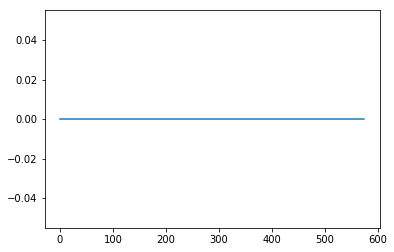

In [146]:
import matplotlib.pyplot as plt
plt.plot(np.array(weights)-np.array(weights2))


In [107]:
%autoreload 2

In [172]:
GateFidelityRauli(qiskit.tools.qi.qi.choi_to_rauli(choi_cvx)/4,qiskit.tools.qi.qi.choi_to_rauli(choi_ideal)/4)

((0.965747094569017+7.435772726481358e-07j),
 (0.9725976756552136+5.948618181185087e-07j))

In [74]:
def GateFidelityRauli(raulitheory,rauliexp):
    
    #len(rauliexp) is 4**nq
    #hspace (hilbert space) is 2**nq
    hspace = np.log(len(rauliexp))/np.log(2)
    fidp=np.trace(np.dot(np.transpose(raulitheory),rauliexp))/len(rauliexp)
    fidg=(hspace*fidp+1)/(hspace+1)
    
    return fidp,fidg